# TalkingData (Kaggle)
## Pre-processing

### Import

In [13]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
!pip install lightgbm
!pip install xgboost
import lightgbm as lgb
#import xgboost as xgb

grin 1.2.1 requires argparse>=1.1, which is not installed.


  Using cached https://files.pythonhosted.org/packages/4b/c4/57e246bc99e45c048f9805f2773e7369f0d30896d19fa089fa1794c7b246/xgboost-0.71.tar.gz


No files/directories in c:\users\nguy3409\appdata\local\temp\pip-install-nocyyo\xgboost\pip-egg-info (from PKG-INFO)


### Load in data

In [ ]:
DATA_PATH = r"C:\Users\nguy3409\TalkingData-master"

def load_data(data_path=DATA_PATH):
    # PATHS TO FILE
    train_path = os.path.join(data_path, "train.csv")
    test_path = os.path.join(data_path, "test.csv")
    #ssize = 100000
    #return pd.read_csv(train_path,nrows=ssize), pd.read_csv(test_path)
    return pd.read_csv(train_path), pd.read_csv(test_path)

train, test = load_data()

### Data Exploration

In [ ]:
# Training sample
print(train.shape)
train.head()

In [ ]:
# Describe train
train.dtypes
train.max()

In [ ]:
# Check NAs
train.isnull().sum()

In [ ]:
# Extract data where is_attributed == 1
train_att = train[train['is_attributed']==1]
# Check NAs
train_att.isnull().sum()

We notice that all the missing values in 'attributed_time' are for observations that did not convert into a download ('is_attributed'=0).

In [ ]:
# Percentage of is_attributed == 1
p = len(train_att)/len(train)
print(len(train_att))
print('The percentage of converted clicks is {num:.10%}'.format(num=p))

In [ ]:
# Plot the proportion of clicks that converted into a download or not
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['Converted (1)', 'Not Converted (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='Proportion of clicks converted into app downloads')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

### Undersampling
Sample the data using random undersampling

In [ ]:
# Separate the 2 classes
train_0 = train[train['is_attributed'] == 0]
train_1 = train[train['is_attributed'] == 1]

In [ ]:
print(len(train_1))
print(train_0.shape)
print(train.shape)
train['is_attributed'].value_counts()

In [ ]:
# Undersample class 0 (without replacement)
train0_undersampled = resample(train_0, replace=False, n_samples=len(train_1), random_state=142) 

In [ ]:
# Combine minority class with downsampled majority class
train_us = pd.concat([train0_undersampled, train_1])
 
# Display new class counts
train_us.is_attributed.value_counts()

### Feature Engineering

In [ ]:
# Set categorical variables
cat = ['ip', 'app', 'device', 'os', 'channel']
for c in cat:
    train_us[c] = train_us[c].astype('category')
    test[c]=test[c].astype('category')

# Only training data has is_attributed
train_us['is_attributed'] = train_us['is_attribute'].astype('category')

In [ ]:
# Extract features from click_time
def ppClicktime(df):
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['wday'] = df['click_time'].dt.dayofweek
    df['week'] = df['click_time'].dt.week
    df['hour'] = df['click_time'].dt.hour
    df['minute'] = df['click_time'].dt.minute
    return df
# Pre-process training (undersampled) and testing sets
train_pp = ppClicktime(train_us)
test_pp = ppClicktime(test)

In [ ]:
# Drop click_time
train_pp.drop('click_time', axis = 1, inplace = True)
test_pp.drop('click_time', axis = 1, inplace = True)
print(len(test_pp))
test_pp.head()

In [ ]:
# Write to csv
train_pp.to_csv("train_pp.csv",index=None)
test_pp.to_csv("test_pp.csv",index=None)

### Feature aggregation

In [14]:
# Load in pre-processed files
PP_PATH = r"C:\Users\nguy3409\TalkingData-master"

def load_pp(pp_path=PP_PATH):
    # PATHS TO FILE
    train_pp = os.path.join(pp_path, "train_pp.csv")
    test_pp = os.path.join(pp_path, "test_pp.csv")
    return pd.read_csv(train_pp), pd.read_csv(test_pp)

train_pp, test_pp = load_pp()

In [15]:
# Drop attributed_time
train_pp.drop('attributed_time', axis = 1, inplace = True)

In [34]:
train_pp.head()

,ip,app,device,os,channel,is_attributed,wday,hour
0,26920,2,1,19,236,0,2,4
1,73767,9,1,15,442,0,2,4
2,75931,7,2,13,101,0,1,6
3,83268,12,1,19,245,0,2,6
4,66724,8,1,15,145,0,2,0


In [17]:
# Drop unnecessary features
def drop_ft(df):
    df.drop(['week','minute'],axis=1, inplace=True)
    return df
train_pp = drop_ft(train_pp)
test_pp = drop_ft(test_pp)

Adding new features

In [35]:
def aggregate_features(df):
    # IPs
    n_ip = df[['ip','channel']].groupby(by=['ip'])[['channel']].count().reset_index().rename(index = str, columns={'channel': 'n_ip'})
    df = df.merge(n_ip, on = ['ip'], how = 'left')
    # app count
    ip_app_count = df[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(columns={'channel': 'ip_app_count'})
    df = df.merge(ip_app_count, on = ['ip', 'app'], how = 'left')
    # device count
    ip_device_count = df[['ip','device', 'channel']].groupby(by=['ip', 'device'])[['channel']].count().reset_index().rename(columns={'channel': 'ip_device_count'})
    df = df.merge(ip_device_count, on = ['ip', 'device'], how = 'left')
    # os count
    ip_os_count = df[['ip','os', 'channel']].groupby(by=['ip', 'os'])[['channel']].count().reset_index().rename(columns={'channel': 'ip_os_count'})
    df = df.merge(ip_os_count, on = ['ip', 'os'], how = 'left')
    # wday + hour
    ip_wday_hour = df[['ip', 'wday', 'hour', 'channel']].groupby(by = ['ip','wday','hour'])[['channel']].count().reset_index().rename(index = str, columns = {'channel': 'ip_wday_hour'})
    df = df.merge(ip_wday_hour, on = ['ip', 'wday', 'hour'], how = 'left')
    # app + hour
    ip_app_hour = df[['ip', 'app', 'hour', 'channel']].groupby(by = ['ip','app','hour'])[['channel']].count().reset_index().rename(index = str, columns = {'channel': 'ip_app_hour'})
    df = df.merge(ip_app_hour, on = ['ip', 'app', 'hour'], how = 'left')
    # device + hour
    ip_device_hour = df[['ip', 'device', 'hour', 'channel']].groupby(by = ['ip','device','hour'])[['channel']].count().reset_index().rename(index = str, columns = {'channel': 'ip_device_hour'})
    df = df.merge(ip_device_hour, on = ['ip', 'device', 'hour'], how = 'left')
    # os + hour
    ip_os_hour = df[['ip', 'os', 'hour', 'channel']].groupby(by = ['ip','os','hour'])[['channel']].count().reset_index().rename(index = str, columns = {'channel': 'ip_os_hour'})
    df = df.merge(ip_os_hour, on = ['ip', 'os', 'hour'], how = 'left')
    # app + device + hour
    ip_os_device_hour = df[['ip', 'os', 'device', 'hour', 'channel']].groupby(by = ['ip','os', 'device', 'hour'])[['channel']].count().reset_index().rename(index = str, columns = {'channel': 'ip_os_device_hour'})
    df = df.merge(ip_os_device_hour, on = ['ip', 'os', 'device', 'hour'], how = 'left')
    return df

In [36]:
train_ag = aggregate_features(train_pp)

In [37]:
test_ag = aggregate_features(test_pp)

In [38]:
# Write to csv
train_ag.to_csv("train_ag.csv",index=None)
test_ag.to_csv("test_ag.csv",index=None)

# Modeling

In [ ]:
# Load in aggregated files
PP_PATH = r"C:\Users\reio\Documents\GitHub\TalkingData"

def load_ag(ag_path=PP_PATH):
    # PATHS TO FILE
    train_pp = os.path.join(pp_path, "train_ag.csv")
    test_pp = os.path.join(pp_path, "test_ag.csv")
    return pd.read_csv(train_ag), pd.read_csv(test_ag)

train_ag, test_ag = load_ag()

### Splitting training dataset

In [39]:
# Separate response variables from predictors
y = list(train_ag.is_attributed)
X = train_ag.drop(['is_attributed'],axis=1)
X.head()

,ip,app,device,os,channel,wday,hour,n_ip,ip_app_count,ip_device_count,ip_os_count,ip_wday_hour,ip_app_hour,ip_device_hour,ip_os_hour,ip_os_device_hour
0,26920,2,1,19,236,2,4,27,4,23,7,1,2,4,2,2
1,73767,9,1,15,442,2,4,40,5,27,1,2,1,4,1,1
2,75931,7,2,13,101,1,6,27,1,8,9,2,1,2,1,1
3,83268,12,1,19,245,2,6,21,5,15,3,1,1,1,1,1
4,66724,8,1,15,145,2,0,17,1,16,1,1,1,5,1,1


In [40]:
# Drop ip
X = X.drop(['ip'],axis=1)

In [24]:
len(y)

913692

In [41]:
# Split the training data into training and test sets for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Logistic Regression

In [ ]:
# Fit model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Predict on test set
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)
# AUC
metrics.roc_auc_score(y_test, y_pred_prob[:,1])

### Random Forest

In [ ]:
# Fit model
Ntree = 500
rfc = RandomForestClassifier(n_estimators=Ntree)
rfc.fit(X_train, y_train)
# Predict on test set
y_pred = rfc.predict(X_test)
y_pred_prob = rfc.predict_proba(X_test)
# AUC
metrics.roc_auc_score(y_test, y_pred_prob[:,1])

### Light GBM

In [42]:
target = 'is_attributed'
predictors = ['device', 'app', 'os', 'channel', 'wday', 'hour',
              'n_ip', 'ip_app_count', 'ip_device_count', 'ip_os_count',
              'ip_wday_hour', 'ip_app_hour', 'ip_device_hour', 
              'ip_os_hour', 'ip_os_device_hour']
categorical = ['app', 'device', 'os', 'channel', 'wday', 'hour']

In [43]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 255,  
    'max_depth': 8,  
    'min_child_samples': 100,  
    'max_bin': 100,  
    'subsample': 0.7,  
    'subsample_freq': 1,  
    'colsample_bytree': 0.7,  
    'min_child_weight': 0,  
    'subsample_for_bin': 200000,  
    'min_split_gain': 0,  
    'reg_alpha': 0,  
    'reg_lambda': 0,  
   # 'nthread': 8,
    'verbose': 0,
    }

In [44]:
dtrain = lgb.Dataset(X_train[predictors].values, label=y_train,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
dvalid = lgb.Dataset(X_test.values, label=y_test,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

In [45]:
evals_results = {}
lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=350,
                 early_stopping_rounds=30,
                 verbose_eval=True, 
                 feval=None)

[1]	train's auc: 0.960283	valid's auc: 0.953071
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.961093	valid's auc: 0.95167
[3]	train's auc: 0.966073	valid's auc: 0.949808
[4]	train's auc: 0.967772	valid's auc: 0.9476
[5]	train's auc: 0.968002	valid's auc: 0.950145
[6]	train's auc: 0.967968	valid's auc: 0.954998
[7]	train's auc: 0.968814	valid's auc: 0.953765
[8]	train's auc: 0.96958	valid's auc: 0.953716
[9]	train's auc: 0.970133	valid's auc: 0.953293
[10]	train's auc: 0.970194	valid's auc: 0.953165
[11]	train's auc: 0.970676	valid's auc: 0.95294
[12]	train's auc: 0.970949	valid's auc: 0.952536
[13]	train's auc: 0.971192	valid's auc: 0.951946
[14]	train's auc: 0.971435	valid's auc: 0.951792
[15]	train's auc: 0.971723	valid's auc: 0.951494
[16]	train's auc: 0.972034	valid's auc: 0.951321
[17]	train's auc: 0.972239	valid's auc: 0.951133
[18]	train's auc: 0.972447	valid's auc: 0.950829
[19]	train's auc: 0.972625	valid's auc: 0.950676
[20]	train's auc: 0.9

### XGBoost

## Prediction

In [46]:
# Predict on test dataset and write out submission file
test2 = test_ag.drop(['click_id','ip'],axis=1)

In [47]:
test2.head()

,app,device,os,channel,wday,hour,n_ip,ip_app_count,ip_device_count,ip_os_count,ip_wday_hour,ip_app_hour,ip_device_hour,ip_os_hour,ip_os_device_hour
0,9,1,3,107,4,4,91,28,91,3,34,8,34,3,3
1,9,1,3,466,4,4,2083,289,2069,43,403,50,400,17,17
2,21,1,19,128,4,4,2135,312,2092,197,229,13,229,69,69
3,15,1,13,111,4,4,1201,42,1190,328,239,10,239,98,98
4,12,1,13,328,4,4,208,24,203,49,60,7,59,27,27


In [ ]:
rfc.fit(X,y)

In [48]:
#y_submit = rfc.predict(test2)
y_submit = lgb_model.predict(test2[predictors],num_iteration=lgb_model.best_iteration)

In [49]:
test_ag['is_attributed'] = y_submit
ans = test_ag[['click_id', 'is_attributed']]

In [50]:
ans.to_csv('submission3.csv', index=None)

In [51]:
ans.shape

(18790469, 2)

## Feature Importance

In [52]:
from lightgbm import plot_importance

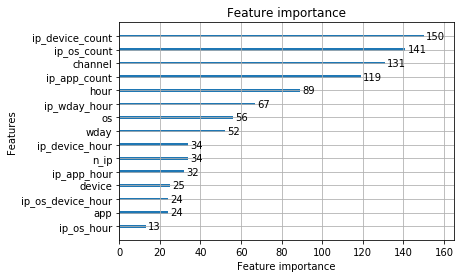

In [53]:
# Plot the feature importance from xgboost
plot_importance(lgb_model)
plt.gcf().savefig('feature_importance_lgb.png')